In [1]:
import pandas as pd
import os
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show_hist, reshape_as_raster, reshape_as_image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

os.chdir("/home/b/bac14/Documents/dissertation/data")
df = pd.read_csv("aggregated_training_data.csv")
df = df.drop(columns=['Unnamed: 0'], axis=1)


print("df has", df.shape[0], "rows,", df.shape[1], "columns.")
print("Number of scenes:", len(df.scene.unique().tolist()))
print("Burn classes:", df.burn_class.unique().tolist())
df.head(10)

df has 6319921 rows, 15 columns.
Number of scenes: 37
Burn classes: [3, 1, 2]


,scene,pre_date,post_date,interval_days,pre_b4,pre_b8,pre_b12,post_b4,post_b8,post_b12,pre_NBR,post_NBR,dNBR,burn_class,pre_month
0,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1572,2730,2074,1554,2510,2100,0.136553,0.088937,-0.047616,3,12.0
1,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1508,2778,2041,1494,2568,2064,0.152936,0.108808,-0.044128,3,12.0
2,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1502,2720,2041,1404,2532,2064,0.142617,0.101828,-0.040789,3,12.0
3,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1520,2764,2050,1440,2568,2095,0.148317,0.101437,-0.046881,3,12.0
4,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1598,2652,2081,1548,2416,2083,0.120642,0.074016,-0.046626,3,12.0
5,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1606,2676,2081,1554,2458,2083,0.125079,0.082581,-0.042498,3,12.0
6,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1606,2698,2134,1570,2486,2116,0.116722,0.080400,-0.036322,3,12.0
7,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1602,2708,2134,1582,2530,2116,0.118546,0.089109,-0.029437,3,12.0
8,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1600,2720,2074,1532,2496,2100,0.134752,0.086162,-0.048590,3,12.0
9,S2A_20191221_S2A_20191231_T55HGA_R030,2019-12-21,2019-12-31,10,1566,2764,2074,1542,2534,2100,0.142621,0.093656,-0.048965,3,12.0


## Training a baseline Random Forest classification

The baseline Random Forest classification will be trained on the features used in the AI4EO Burned Area Mapping project, namely `pre_b4`, `pre_b8`, `pre_b12`, `post_b4`, `post_b8`, `post_b12`, `pre_NBR`, `post_NBR` and `dNBR`. In addition, `pre_month` and `interval_days` will also be included.

In [2]:
def rf_classify(df, X_varnames, Y_varname):
    # Select predictor variables
    X = df[X_varnames]
    # Want to predict award
    Y = df[Y_varname].astype('int')
    # Create train test split using 20% of the rows to test the model and stratified on burn_class
    trainX, testX, trainY, testY=train_test_split(X, Y, stratify=Y, test_size=0.2)

    # Create Random Forest classifier model
    rf = RandomForestClassifier(n_jobs=-1, oob_score=True)
    rf.fit(trainX,trainY)
    train_score = rf.score(trainX, trainY)
    test_score = rf.score(testX, testY)
    oob_score = rf.oob_score_
    print('Accuracy score for training data is: {:4.3f}'.format(train_score))
    print('Accuracy score for test data: {:4.3f}'.format(test_score))
    print('The Oob score is: {:4.3f}'.format(oob_score))
    
    return rf, X, Y, trainX, testX, trainY, testY #rf, X, Y, trainX, testX, trainY, testY

# Select columns
columns = ['pre_b4', 'pre_b8', 'pre_b12', 'post_b4', 'post_b8', 'post_b12', 
           'pre_NBR', 'post_NBR', 'dNBR', 'pre_month', 'interval_days']

# Train and test baseline rf model
rf_baseline, X, Y, trainX, testX, trainY, testY = rf_classify(df, columns, 'burn_class')

Accuracy score for training data is: 1.000
Accuracy score for test data: 0.997
The Oob score is: 0.997


### Confusion matrix

In [3]:
# Confusion matrix
def confusion_matrix(model, X, Y):
    predicted = model.predict(X)
    y_actu = pd.Series(list(Y), name='Actual')
    y_pred = pd.Series(predicted, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    return df_confusion
    
confusion_baseline_df = confusion_matrix(rf_baseline, testX, testY)
confusion_baseline_df

Predicted,1,2,3
Actual,,,
1,102552,209,1470
2,809,536667,687
3,435,275,620881


In [11]:
# Confusion matrix
def confusion_matrix(model, X, Y):
    predicted = model.predict(X)
    y_actu = pd.Series(list(Y), name='Actual')
    y_pred = pd.Series(predicted, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    return df_confusion
    
confusion_baseline_df = confusion_matrix(rf_baseline, testX, testY)
confusion_baseline_df

Predicted,1,2,3
Actual,,,
1,102468,252,1511
2,834,536648,681
3,438,326,620827


### Cross validation

In [6]:
# KFold cross validation of the model
def KFold_cross_val(model, K, X, Y):
    crossvalidation = KFold(K, shuffle=True)
    scores = cross_val_score(model, X, Y,scoring='accuracy',cv=crossvalidation,n_jobs=None)
    print('X validation score for Random Forest: {:5.4f}'.format(np.mean(scores)))
    print('All scores: \n', scores)
    return scores

rf_cross_val_scores = KFold_cross_val(rf_baseline, 6, X, Y)

KeyboardInterrupt: 

## PCA

In [4]:
trainX

,pre_b4,pre_b8,pre_b12,post_b4,post_b8,post_b12,pre_NBR,post_NBR,dNBR,pre_month,interval_days
4592013,1434,1610,13774,565,1142,952,-0.790692,0.090735,0.881427,12.0,10
2913564,2278,2756,3829,1958,2542,3858,-0.162946,-0.205625,-0.042679,10.0,10
1244522,208,143,155,248,354,162,-0.040268,0.372093,0.412361,12.0,10
1512560,155,130,118,218,211,205,0.048387,0.014423,-0.033964,12.0,5
5931898,2636,3958,3210,695,988,1939,0.104353,-0.324906,-0.429259,12.0,15
...,...,...,...,...,...,...,...,...,...,...,...
883293,97,67,86,165,169,169,-0.124183,0.000000,0.124183,12.0,10
4507848,832,730,574,11104,10800,4052,0.119632,0.454350,0.334718,12.0,10
5633674,2204,3544,2327,289,1500,670,0.207290,0.382488,0.175198,11.0,35
4439925,7436,7848,6611,2416,3406,4505,0.085552,-0.138920,-0.224473,12.0,10


In [5]:
# Normalise the training and testing data using Min/Max Normalisation
scaler = MinMaxScaler()
scaler.fit(X)
trainX_norm = scaler.transform(trainX)
testX_norm = scaler.transform(testX)

# Export the scaler to apply to scenes for validation
#joblib.dump(scaler, "/home/b/bac14/Documents/dissertation/data/pkl_files/MinMaxScaler.pkl")

In [11]:
trainX_norm[1]

array([0.1449303 , 0.17890772, 0.24049758, 0.11294511, 0.15494847,
       0.24257862, 0.41961517, 0.3970649 , 0.46311722, 0.81818182,
       0.05747126])

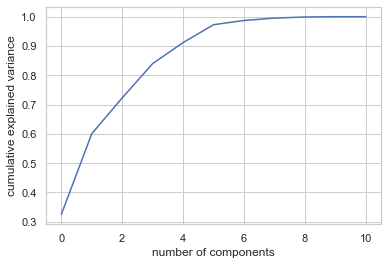

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.325305,0.325305
1,0.600550,0.275246
2,0.722954,0.122403
3,0.839830,0.116876
4,0.911678,0.071848
5,0.972611,0.060933
6,0.987098,0.014488
7,0.995184,0.008086
8,0.998968,0.003784
9,1.000000,0.001032


In [6]:
# Fit PCA test model with 11 components
pca_test = PCA(n_components=11)
pca_test.fit(trainX_norm, trainY)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
#plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [7]:
pca = PCA(n_components=6)
pca.fit(trainX_norm)
trainX_pca = pca.transform(trainX_norm)
testX_pca = pca.transform(testX_norm)

In [9]:
testX_pca.shape

(1263985, 6)

In [16]:
pca = PCA(n_components=6)
pca.fit(trainX_norm)
trainX_pca = pca.transform(trainX_norm)
testX_pca = pca.transform(testX_norm)

# Create Random Forest classifier model
rf_pca = RandomForestClassifier(n_jobs=-1, oob_score=True)
rf_pca.fit(trainX_pca,trainY)
train_score = rf_pca.score(trainX_pca, trainY)
test_score = rf_pca.score(testX_pca, testY)
oob_score = rf_pca.oob_score_
print('Accuracy score for training data is: {:4.3f}'.format(train_score))
print('Accuracy score for test data: {:4.3f}'.format(test_score))
print('The Oob score is: {:4.3f}'.format(oob_score))

Accuracy score for training data is: 1.000
Accuracy score for test data: 0.992
The Oob score is: 0.991


In [17]:
df_confusion_pca = confusion_matrix(rf_pca, testX_pca, testY)
df_confusion_pca

Predicted,1,2,3
Actual,,,
1,98480,406,1065
2,1259,526809,1020
3,476,492,560601


In [29]:
weights = pca.components_
weights

pca_df = pd.DataFrame(
    weights, 
    columns = ['pre_b4', 'pre_b8', 'pre_b12', 'post_b4', 'post_b8', 'post_b12', 
           'pre_NBR', 'post_NBR', 'dNBR', 'pre_month', 'interval_days']
)
pca_df['Principal component'] = range(1,len(pca_df)+1)
pca_df

,pre_b4,pre_b8,pre_b12,post_b4,post_b8,post_b12,pre_NBR,post_NBR,dNBR,pre_month,interval_days,Principal component
0,0.111079,0.120320,0.113377,0.499991,0.497862,0.153117,-0.093780,0.214264,0.179452,0.589458,-0.068267,1
1,-0.040293,-0.011834,0.064381,0.360967,0.383689,0.104319,-0.120267,0.119212,0.139376,-0.787178,-0.194795,2
2,0.365023,0.380176,0.110632,0.039003,0.068994,-0.016856,0.268601,0.180302,-0.050759,-0.174896,0.752063,3
3,0.321037,0.319909,0.319825,-0.020241,-0.015351,0.386152,-0.281588,-0.636656,-0.207943,-0.021372,-0.119273,4
4,-0.203528,-0.236106,0.145999,-0.030928,-0.046141,-0.070644,-0.700247,-0.088783,0.354763,0.012697,0.499192,5
5,-0.381171,-0.323663,-0.308425,0.215303,0.195913,0.436970,0.223539,-0.319415,-0.316136,0.024734,0.355802,6


<AxesSubplot:title={'center':'PCA Analysis'}, xlabel='Principal component'>

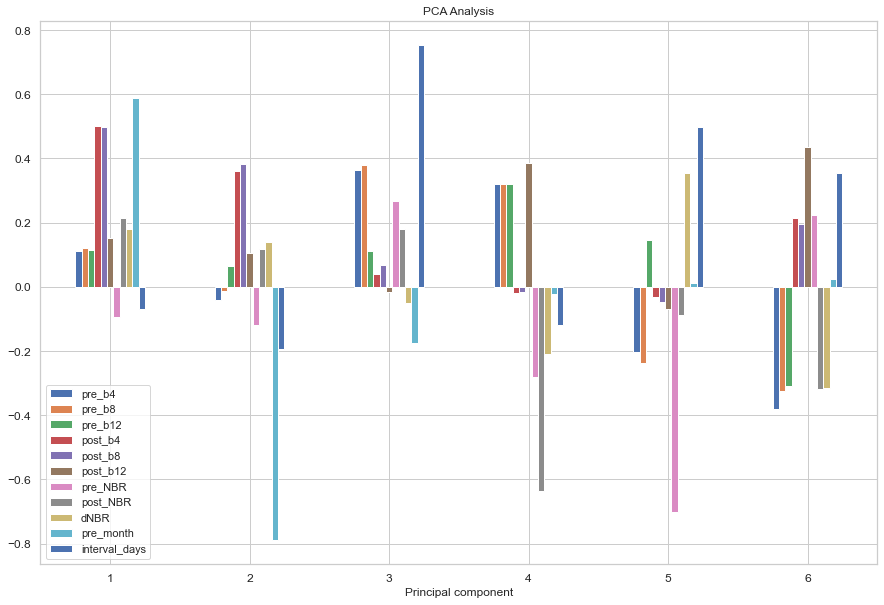

In [30]:
pca_df.plot.bar(x='Principal component', rot=0, title='PCA Analysis', figsize=(15,10), fontsize=12)

In [ ]:
#rf_cross_val_scores = KFold_cross_val(rf, 6, X, Y)

## Export the models

In [32]:
joblib.dump(rf_baseline, "pkl_files/rf_baseline.pkl")

joblib.dump(pca, "pkl_files/pca.pkl")
joblib.dump(rf_pca, "pkl_files/rf_pca.pkl")

['pkl_files/rf_pca.pkl']